<a href="https://colab.research.google.com/github/ryanraba/casa6/blob/master/casa7experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup libraries, tools, data etc


In [1]:
import os
print("installing pre-requisite packages...")
os.system("pip install pyarrow")
os.system("pip install tables --upgrade")  # need latest version to load hdf5 correctly
os.system("apt-get install libgfortran3")

print("installing casatasks...")
os.system("pip install --extra-index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casatools")
os.system("pip install --extra-index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casatasks")

print("downloading MeasurementSet from CASAguide First Look at Imaging")
os.system("wget https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar")
os.system("tar -xvf sis14_twhya_calibrated_flagged.ms.tar")

print('complete')

installing pre-requisite packages...
installing casatasks...
downloading MeasurementSet from CASAguide First Look at Imaging
complete


In [0]:
# keep this updated if dataset changes
prefix = 'sis14_twhya_calibrated_flagged'

# Convert MS to HDF5 and Apache Parquet formats

In [9]:
from casatools import table as tb
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import warnings
import os
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

print("processing MS...")

MS = tb(prefix+'.ms')
MS.open(prefix+'.ms')
cols = MS.colnames()

# build python dictionary one MS column at a time
md = {}
for col in cols:
  if MS.isvarcol(col):  # this is a woefully unhelpful way to return data
    varcol = MS.getvarcol(col)
    md[col] = [varcol['r'+str(ii+1)] for ii in range(len(varcol))]
    if np.ndim(md[col][0]) > 1: # get rid of nested multi-dimensional arrays
      md[col] = [np.squeeze(md[col][rr]) for rr in range(len(md[col]))]
      for cc in range(md[col][0].shape[0]): # split smaller dimension in to separate cols
        md[col+str(cc)] = [md[col][rr][cc] for rr in range(len(md[col]))]
      md.pop(col, None)
  else:  # would have been nice if both methods had just returned lists of arrays
    md[col] = list(np.squeeze(MS.getcol(col)))

MS.close()

# we need to fix up a few things
# first, split out UVW in to separate columns
print('cleaning up dataframe...')
md['UU'] = md['UVW'][0]
md['VV'] = md['UVW'][1]
md['WW'] = md['UVW'][2]
md.pop('UVW',None)

# now let's compress the nested flag arrays in to strings
for label in ['FLAG0', 'FLAG1']:
  flags = md[label]
  md[label] = [np.array_str(flags[rr], max_line_width=9999999) for rr in range(len(flags))]

print("writing to Parquet...")
# for some reason, Parquet doesn't seem to like bool or complex arrays
# so we need to convert everything to int or float arrays instead
mdf = pd.DataFrame(data=md)
mdf['DATA0R'] = [np.real(mdf.DATA0[rr]) for rr in range(len(mdf))]
mdf['DATA0I'] = [np.imag(mdf.DATA0[rr]) for rr in range(len(mdf))]
mdf['DATA1R'] = [np.real(mdf.DATA1[rr]) for rr in range(len(mdf))]
mdf['DATA1I'] = [np.imag(mdf.DATA1[rr]) for rr in range(len(mdf))]
cols = [col for col in mdf.keys() if col not in ['DATA0', 'DATA1']]
os.system("rm -r *.parquet") # doesn't like to overwrite existing files
pq.write_to_dataset(pa.Table.from_pandas(mdf[cols]), 
                    root_path=prefix+'.parquet',
                    flavor='spark',
                    partition_cols=['ANTENNA1','ANTENNA2'])

# nested arrays in the dataframe columns can be a pain
# so we'll split out these instances in to separate columns
print('flattening dataframe...')
for label in ['DATA0', 'DATA1']:
  tmp = np.array(md[label])
  for chan in range(tmp.shape[1]):
    md[label+'_'+str(chan)] = tmp[:,chan]
  md.pop(label, None)

print("writing to HDF5...")
mdf = pd.DataFrame(data=md)
mdf.to_hdf(prefix+'.h5', key='mdf', mode='w')    # faster format for pandas and tensorflow
mdf.to_hdf(prefix+'.d.h5', key='mdf', mode='w', format='table')  # chunkable format for dask

print("complete")

processing MS...
cleaning up dataframe...
writing to Parquet...
flattening dataframe...
writing to HDF5...
complete


In [0]:
# free memory
md, mdf, tmp, flags = [[],[],[],[]]

# CPU Processing with Pandas/Numpy

In [3]:
import numpy as np
import pandas as pd
import time

# load pandas dataframe
pdf = pd.read_hdf(prefix+'.h5', key='mdf')

d0 = pdf.columns.values[pdf.columns.str.startswith('DATA0_')]
d1 = pdf.columns.values[pdf.columns.str.startswith('DATA1_')]

# start the race
start = time.time()

################################################################
# I don't really know what we do with the second set of points, so lets just average in to the first
# if the following operations don't make sense, check out the DataFrame tutorial at the bottom of this notebook
vis = (pdf[d0].values + pdf[d1].values)/2
vdf = pd.DataFrame(vis)

CONT_RMS = vdf.abs().pow(2).mean(axis=1).pow(0.5)
CONT_MAX = vdf.abs().max(axis=1)
CONT_STD = vdf.abs().std(axis=1)

################################################################
print('pandas elapsed time (s): ', time.time() - start)

print(vdf.iloc[99].values[:10])
print(CONT_RMS.values)
print(CONT_MAX.values)
print(CONT_STD.values)


pandas elapsed time (s):  5.0751426219940186
[13.54471254 -4.17907533j 11.38541317 -1.468117j
  6.51205455 -0.63292367j  4.22940874 -8.97885489j
 16.40296173 -3.08799507j  7.35137585 -1.7305609j
  4.10938323 -3.54848051j 10.18194199 -1.71122259j
  9.92670894 -4.06110525j  4.69709611-13.00634623j]
[10.4100553  10.48297409 10.37487385 ... 10.95658076 10.37941196
  8.49994653]
[25.62491703 21.06853462 21.71281421 ... 29.41012952 27.53062948
 27.83868841]
[4.14727133 4.16223349 3.88061166 ... 5.05826952 4.64526106 4.07835405]


#  CPU Processing with Apache Spark
https://spark.apache.org/docs/latest/api/python/index.html

https://spark.apache.org/docs/latest/rdd-programming-guide.html

In [25]:
# install and configure PySpark
import os
print("installing spark...")
os.system("apt-get install openjdk-8-jdk-headless -qq")
os.system("pip install findspark")
os.system("wget https://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz")
os.system("tar -xvzf spark-2.4.3-bin-hadoop2.7.tgz")

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"
print('complete') 

installing spark...
complete


In [26]:
print('initializing spark...') 
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.config('spark.driver.memory', '6g')
spark = spark.config('spark.executor.memory', '4g')
spark = spark.config('spark.executor.cores', '4')
spark = spark.config('spark.sql.execution.arrow.enabled', 'True')
spark = spark.master("local[*]").getOrCreate()
spark.sparkContext._conf.getAll() 

initializing spark...


[('spark.executor.memory', '4g'),
 ('spark.driver.host', '15ea9e1473ae'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.executor.cores', '4'),
 ('spark.driver.port', '34047'),
 ('spark.app.id', 'local-1560109208243'),
 ('spark.driver.memory', '6g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.deployMode', 'client'),
 ('spark.sql.execution.arrow.enabled', 'True'),
 ('spark.ui.showConsoleProgress', 'true')]

In [35]:
import numpy as np
import time

# load spark dataframe
sdf = spark.read.parquet(prefix+'.parquet')
sdf.cache()
sdf.count() # trigger a load to cache data in memory

# start the race
start = time.time()

################################################################
# here are our map operations to be run on each row independently
def processElement(element):  
  c0 = (np.array(element.DATA0R) + 1j*np.array(element.DATA0I)).astype(np.complex64)
  c1 = (np.array(element.DATA1R) + 1j*np.array(element.DATA1I)).astype(np.complex64)
  vis = (c0 + c1)/2
  
  CONT_RMS = np.sqrt(np.mean(np.power(np.abs(vis),2), axis=0))
  CONT_MAX = np.max(np.abs(vis), axis=0)
  CONT_STD = np.std(np.abs(vis), axis=0)
  
  return vis, CONT_RMS, CONT_MAX, CONT_STD
  
# fire off our map function
prdd = sdf.rdd.map(lambda row: processElement(row)).collect()

################################################################
print('spark elapsed time (s): ', time.time() - start)

print(np.array(prdd)[99][0][:10])
print(np.array(prdd)[:,1])
print(np.array(prdd)[:,2])
print(np.array(prdd)[:,3])

spark elapsed time (s):  33.90123462677002
[15.368347  +3.496803j   2.352149  +6.232252j  -2.8458345 -3.4297054j
 -0.3756826 -4.024106j   2.6655807 -5.9877825j  0.42628008-4.511368j
  3.692929  +4.503709j   7.998578  +6.80622j   11.813255  +4.1906047j
 -1.5166845 +6.9134226j]
[11.02426 10.730138 10.810746 ... 12.037731 11.975934 12.026075]
[24.063694 23.316742 23.461426 ... 29.285095 26.563631 29.69375]
[4.315754 4.5817556 4.179552 ... 5.626123 5.6413765 5.4935527]


# CPU Processing with Dask
https://examples.dask.org/dataframe.html

In [2]:
# if you've been doing other things, you might want to refresh the runtime before doing this
# go to Runtime -> Restart runtime
# then execute the prefix cell at the top to reset the prefix (data files will be kept on disk)

print("installing dask...")
import os
os.system('pip install "dask[complete]"')

from dask.distributed import Client
client = Client(processes=False, threads_per_worker=4, n_workers=1, memory_limit='4GB')
client

installing dask...


Client Scheduler: inproc://172.28.0.2/4210/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 4 Memory: 4.00 GB


In [4]:
import numpy as np
import dask.dataframe as dd
import time

# load dask dataframe
ddf = dd.read_hdf(prefix+'.d.h5', key='mdf', chunksize=1000)

# cache as much as possible in memory to avoid unfair time penalty from disk io
#ddf = client.persist(ddf)

d0 = ddf.columns.values[ddf.columns.str.startswith('DATA0_')]
d1 = ddf.columns.values[ddf.columns.str.startswith('DATA1_')]

# start the race
start = time.time()

################################################################
# these are dask arrays, not numpy arrays 
# they hold no value until .execute() is called later on (lazy execution)
vis = (ddf[d0].values + ddf[d1].values)/2

# lets do some math to take up time
# apparently you can apply numpy functions to dask arrays, and still get dask arrays back
CONT_RMS = np.sqrt(np.mean(np.power(np.abs(vis),2), axis=1)).compute()
CONT_MAX = np.max(np.abs(vis), axis=1).compute()
CONT_STD = np.std(np.abs(vis), axis=1).compute()

################################################################
print('dask elapsed time (s): ', time.time() - start)

print(vis.compute()[99,:10])  # fair to call compute here outside of timing
print(CONT_RMS)
print(CONT_MAX)
print(CONT_STD)

dask elapsed time (s):  48.35733914375305
[13.54471254 -4.17907533j 11.38541317 -1.468117j
  6.51205455 -0.63292367j  4.22940874 -8.97885489j
 16.40296173 -3.08799507j  7.35137585 -1.7305609j
  4.10938323 -3.54848051j 10.18194199 -1.71122259j
  9.92670894 -4.06110525j  4.69709611-13.00634623j]
[10.4100553  10.48297409 10.37487385 ... 10.95658076 10.37941196
  8.49994653]
[25.62491703 21.06853462 21.71281421 ... 29.41012952 27.53062948
 27.83868841]
[4.14186771 4.15681038 3.87555548 ... 5.05167894 4.6392086  4.07304023]


In [0]:
client.close()

# GPU Processing with Tensorflow
https://www.tensorflow.org/api_docs/python/tf

In [6]:
import pandas as pd
import tensorflow as tf
import numpy as np
import time

# load pandas dataframe
pdf = pd.read_hdf(prefix+'.h5', key='mdf')

d0 = pdf.columns.values[pdf.columns.str.startswith('DATA0_')]
d1 = pdf.columns.values[pdf.columns.str.startswith('DATA1_')]

start = time.time()

###########################################################################
# create our tensor math sequence
with tf.device('/gpu:0'):
  c0 = pdf[d0].values  # first set of complex visibilities
  c1 = pdf[d1].values  # second set of complex visibilities
  
  aa = tf.placeholder(tf.complex64, shape=c0.shape)
  bb = tf.placeholder(tf.complex64, shape=c1.shape)
  tvis = tf.scalar_mul(0.5, tf.add(aa, bb))
  
  # lets do some math to take up time
  tCONT_RMS = tf.sqrt( tf.reduce_mean( tf.square( tf.abs(tvis) ), axis=1) )          
  tCONT_MAX = tf.reduce_max( tf.abs(tvis), axis=1)
  tCONT_STD = tf.math.reduce_std( tf.abs(tvis), axis=1)

with tf.Session() as sess:    
    vis = sess.run(tvis, feed_dict={aa: c0, bb: c1})
    CONT_RMS = sess.run(tCONT_RMS, feed_dict={aa: c0, bb: c1})
    CONT_MAX = sess.run(tCONT_MAX, feed_dict={aa: c0, bb: c1})
    CONT_STD = sess.run(tCONT_STD, feed_dict={aa: c0, bb: c1})

###########################################################################

print('tensorflow elapsed time (s): ', time.time() - start)

print(vis[99,:10])
print(CONT_RMS)
print(CONT_MAX)
print(CONT_STD)


tensorflow elapsed time (s):  2.418553113937378
[13.544712  -4.1790752j  11.385413  -1.468117j    6.5120544 -0.63292366j
  4.2294087 -8.978855j   16.402962  -3.087995j    7.351376  -1.7305609j
  4.109383  -3.5484805j  10.181942  -1.7112226j   9.926709  -4.0611053j
  4.697096 -13.006346j  ]
[10.410055 10.482974 10.374873 ... 10.956581 10.379413  8.499947]
[25.624916 21.068535 21.712816 ... 29.41013  27.530628 27.838688]
[4.1418676 4.1568103 3.8755555 ... 5.051679  4.639209  4.07304  ]


# Brief Intro to Dataframes
Our MS is now represented as a Dataframe in Python.  Most of these examples will leverage that structure as the Dataframe concept is used by Pandas, Spark, and Dask.  Here is a brief tutorial for those unfamiliar with the original Pandas Dataframe concept.

Pandas is a popular data analytics package for Python built over numpy and matplotlib.  Subsequent frameworks such as Spark have extended the Pandas concept to parallel/scalable processing.

https://pandas.pydata.org/


BTW, variable names that end in 'df' are dataframes

In [8]:
import pandas as pd
import numpy as np

# load pandas dataframe
pdf = pd.read_hdf(prefix+'.h5', key='mdf')

# what do we have here?
pdf.head()

,FLAG0,FLAG1,FLAG_CATEGORY,WEIGHT0,WEIGHT1,SIGMA0,SIGMA1,ANTENNA1,ANTENNA2,ARRAY_ID,DATA_DESC_ID,EXPOSURE,FEED1,FEED2,FIELD_ID,FLAG_ROW,INTERVAL,OBSERVATION_ID,PROCESSOR_ID,SCAN_NUMBER,STATE_ID,TIME,TIME_CENTROID,WEIGHT_SPECTRUM,UU,VV,WW,DATA0_0,DATA0_1,DATA0_2,DATA0_3,DATA0_4,DATA0_5,DATA0_6,DATA0_7,DATA0_8,DATA0_9,DATA0_10,DATA0_11,DATA0_12,...,DATA1_344,DATA1_345,DATA1_346,DATA1_347,DATA1_348,DATA1_349,DATA1_350,DATA1_351,DATA1_352,DATA1_353,DATA1_354,DATA1_355,DATA1_356,DATA1_357,DATA1_358,DATA1_359,DATA1_360,DATA1_361,DATA1_362,DATA1_363,DATA1_364,DATA1_365,DATA1_366,DATA1_367,DATA1_368,DATA1_369,DATA1_370,DATA1_371,DATA1_372,DATA1_373,DATA1_374,DATA1_375,DATA1_376,DATA1_377,DATA1_378,DATA1_379,DATA1_380,DATA1_381,DATA1_382,DATA1_383
0,[False False False False False False False Fal...,[False False False False False False False Fal...,False,20.415682,26.796448,0.221319,0.193180,1,2,0,0,6.048,0,0,0,False,6.048,0,2,4,0,4.860027e+09,4.860027e+09,False,95.583330,-138.672313,-13.694759,(2.3318817615509033-3.5661864280700684j),(8.517426490783691+5.2483296394348145j),(16.66013526916504+6.8231987953186035j),(7.182509422302246+0.08891031891107559j),(10.832413673400879+4.374227046966553j),(0.6358211636543274-0.7716213464736938j),(2.1642746925354004+4.399510860443115j),(8.17321491241455+2.7197201251983643j),(13.39111614227295-6.9550018310546875j),(3.2065072059631348-4.231297969818115j),(15.346712112426758-4.567995548248291j),(19.855609893798828-5.028872966766357j),(5.813932418823242-6.026472091674805j),...,(17.27989959716797+3.3604886531829834j),(8.177420616149902+1.6735318899154663j),(-0.02199137955904007+5.626868724822998j),(20.410009384155273+2.8687903881073j),(3.341310977935791-1.4374526739120483j),(12.33537769317627-4.610698699951172j),(7.492038249969482+6.322351932525635j),(1.3734248876571655-3.6436853408813477j),(1.4769983291625977-0.6867740154266357j),(6.017889022827148+7.395653247833252j),(9.560358047485352-1.985134243965149j),(15.66563606262207-6.449517726898193j),(-4.336203575134277-2.210480213165283j),(-4.779181957244873-6.1192169189453125j),(2.266981363296509+4.905197620391846j),(12.975719451904297-0.42215049266815186j),(4.979161262512207+4.769021987915039j),(4.713338375091553+7.099242210388184j),(4.052988052368164-3.435676336288452j),(3.669857978820801-2.0122134685516357j),(12.932084083557129+0.7047814130783081j),(5.075198650360107-6.040958404541016j),(10.913556098937988+1.3338634967803955j),(9.331941604614258-2.9620518684387207j),(1.9388401508331299-0.5656161904335022j),(14.282381057739258-3.0161337852478027j),(14.715849876403809-3.7254133224487305j),(17.191993713378906-2.0113627910614014j),(2.9381611347198486+3.5896992683410645j),(17.237485885620117-4.860803127288818j),(15.538578987121582+6.01350212097168j),(8.076106071472168-5.437648296356201j),(5.798494338989258+7.236459255218506j),(7.976403713226318+1.227457046508789j),(8.4287109375+5.924354076385498j),(4.802339553833008-8.367317199707031j),(12.765170097351074+2.8492603302001953j),(12.333675384521484-0.745797872543335j),(21.547746658325195+4.049798965454102j),(13.551788330078125-0.7658910751342773j)
1,[False False False False False False False Fal...,[False False False False False False False Fal...,False,19.593037,33.047886,0.225917,0.173951,1,3,0,0,6.048,0,0,0,False,6.048,0,2,4,0,4.860027e+09,4.860027e+09,False,-111.767122,28.948793,42.888321,(20.93869400024414+0.7156710028648376j),(6.29837703704834-9.540606498718262j),(11.93618392944336+5.157202243804932j),(7.319814205169678+4.718991756439209j),(14.039151191711426-5.33660364151001j),(1.3295425176620483-3.44425630569458j),(15.372822761535645-10.89024543762207j),(8.993243217468262+5.282325744628906j),(2.019103527069092-4.335098743438721j),(8.965170860290527+18.955461502075195j),(3.09230637550354+4.113480567932129j),(5.451208591461182-1.2571710348129272j),(1.309105634689331+3.7018072605133057j),...,(22.81267738342285-7.453534126281738j),(1.7387911081314087-14.087273597717285j),(5.526534080505371-12.111541748046875j

In [11]:
# the dataframe holds named columns of scalar values or numpy arrays
print(pdf.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80563 entries, 0 to 80562
Columns: 795 entries, FLAG0 to DATA1_383
dtypes: bool(3), complex128(768), float64(11), int64(11), object(2)
memory usage: 959.7+ MB
None


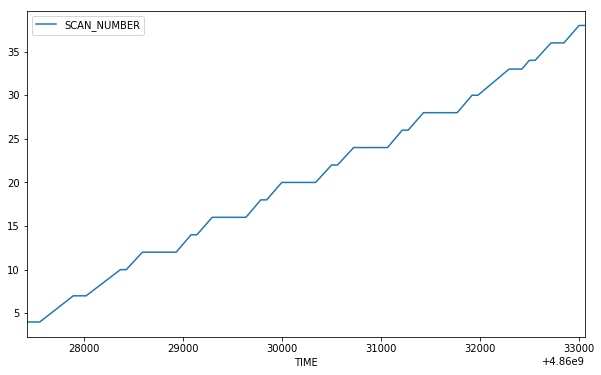

In [12]:
# you can easily visualize things
pdf.plot(x='TIME', y='SCAN_NUMBER', figsize=(10,6))

In [13]:
# one column of a DataFrame is a Series
# you can do math on a Series as you would a numpy array
# the result is a new Series
vis = (pdf.DATA0_0 + pdf.DATA1_0)/2
print(type(vis))
vis.head()

<class 'pandas.core.series.Series'>


0      (8.575416684150696-1.6929169222712517j)
1      (17.93399953842163-2.9816539585590363j)
2      (11.509327411651611+2.421016186475754j)
3    (-0.1800689697265625+6.2383646965026855j)
4      (18.771233081817627+5.290798768401146j)
dtype: complex128

In [20]:
# we can do operations on a slice of multiple columns
# here we will operate on all the visibility channels (each in their own column)
d0 = pdf.columns.values[pdf.columns.str.startswith('DATA0_')]
d1 = pdf.columns.values[pdf.columns.str.startswith('DATA1_')]

# we can find the mean across time for each channels
print(pdf[d0].mean(axis=0).shape)

# and the mean across channels for each time
print(pdf[d0].mean(axis=1).shape)

(384,)
(80563,)


In [22]:
# but you can't add dataframe slices with different column names
# i.e. pdf[d0] + pdf[d1] wont work
# but you can add their underlying numpy arrays
vis = (pdf[d0].values + pdf[d1].values)/2

# so lets make a new DataFrame of size samples x channels from our vis computation
vdf = pd.DataFrame(vis)
print(type(vdf), vdf.shape)

<class 'pandas.core.frame.DataFrame'> (80563, 384)


In [23]:
# now we can do more
# let's make a new DataFrame out of our mean visibilities
# then add U / V coordinates alongside
rdf = pd.DataFrame(vdf.mean(axis=1).abs(), columns=['vis'])
rdf['UU'] = pdf['UU']
rdf['VV'] = pdf['VV']

rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80563 entries, 0 to 80562
Data columns (total 3 columns):
vis    80563 non-null float64
UU     80563 non-null float64
VV     80563 non-null float64
dtypes: float64(3)
memory usage: 1.8 MB


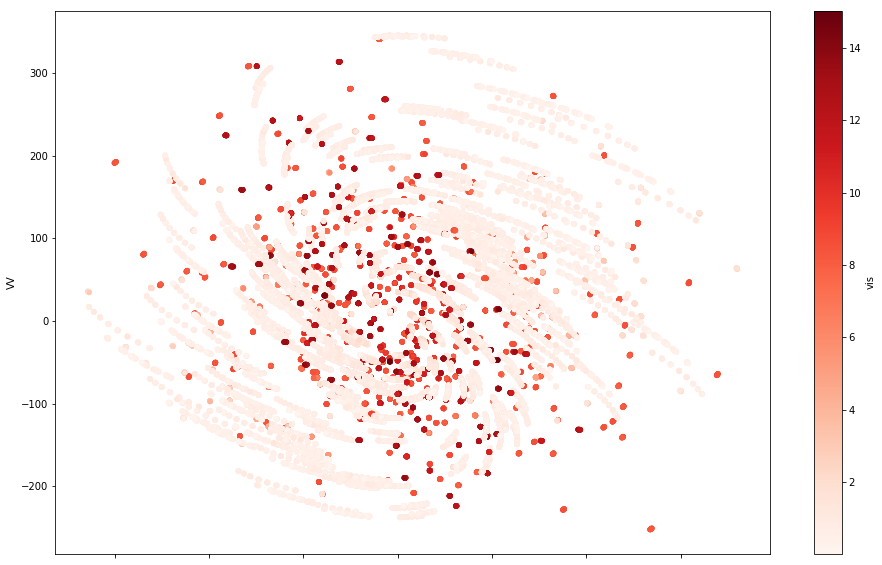

In [24]:
# lets visualize
from matplotlib import cm

rdf.plot(x='UU', y='VV', c='vis', kind='scatter', cmap=cm.get_cmap('Reds'), figsize=(16,10))